In [1]:
import joblib
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split, learning_curve, permutation_test_score, RepeatedStratifiedKFold, cross_val_score
from sklearn.calibration import calibration_curve

from src.data_loader import load_diabetes_data
from src.preprocessing import split_features_target
from src.config import MODEL_PATH

plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['axes.grid'] = True


In [2]:
# Cargar datos limpios usando el data_loader del proyecto
df = load_diabetes_data(clean=True)
X, y = split_features_target(df)

print("Shape del dataset:", X.shape)
print("Proporción de clase positiva (diabéticos):", y.mean())

# Cargar modelo entrenado y umbral óptimo
bundle = joblib.load(MODEL_PATH)
best_model = bundle["model"]
optimal_threshold = bundle["optimal_threshold"]

print("Modelo cargado desde:", MODEL_PATH)
print("Umbral óptimo cargado:", optimal_threshold)


Shape del dataset: (100000, 30)
Proporción de clase positiva (diabéticos): 0.59998
Modelo cargado desde: C:\Users\lohan\DataspellProjects\MachineLearning1\models\modelo_diabetes.joblib
Umbral óptimo cargado: 0.3446788187154708


In [3]:
# División train/test estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Evaluación en TRAIN
y_train_proba = best_model.predict_proba(X_train)[:, 1]
y_train_pred = (y_train_proba >= optimal_threshold).astype(int)

train_roc = roc_auc_score(y_train, y_train_proba)
train_bal = balanced_accuracy_score(y_train, y_train_pred)

print("ROC-AUC Train:", train_roc)
print("Balanced Accuracy Train:", train_bal)

# Evaluación en TEST
y_test_proba = best_model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= optimal_threshold).astype(int)

test_roc = roc_auc_score(y_test, y_test_proba)
test_bal = balanced_accuracy_score(y_test, y_test_pred)

print("ROC-AUC Test:", test_roc)
print("Balanced Accuracy Test:", test_bal)


ROC-AUC Train: 0.6610193587399725
Balanced Accuracy Train: 0.5114414615358052
ROC-AUC Test: 0.6580144687499999
Balanced Accuracy Test: 0.5130416666666667


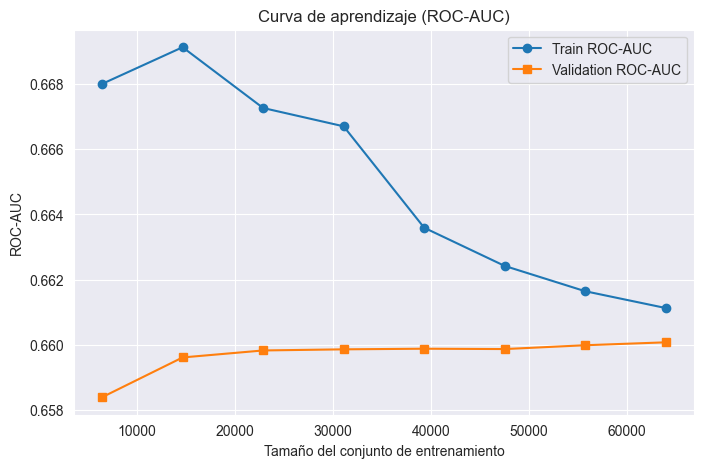

In [4]:
train_sizes, train_scores, val_scores = learning_curve(
    best_model,
    X_train,
    y_train,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 8),
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure()
plt.plot(train_sizes, train_mean, marker='o', label='Train ROC-AUC')
plt.plot(train_sizes, val_mean, marker='s', label='Validation ROC-AUC')
plt.title("Curva de aprendizaje (ROC-AUC)")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("ROC-AUC")
plt.legend()
plt.show()


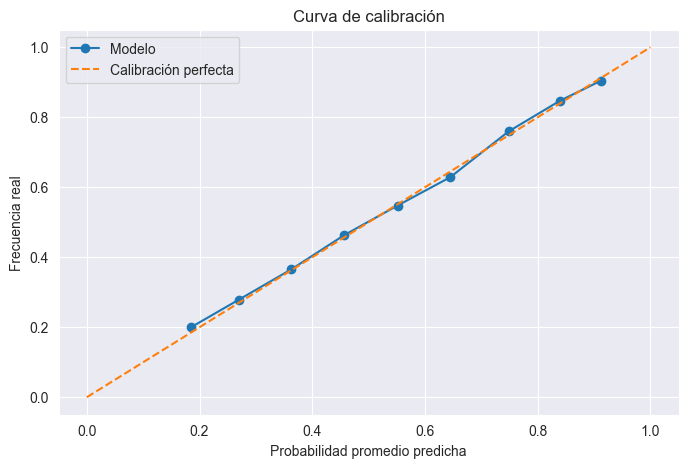

In [5]:
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test, y_test_proba, n_bins=10
)

plt.figure()
plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label='Modelo')
plt.plot([0, 1], [0, 1], '--', label='Calibración perfecta')
plt.title("Curva de calibración")
plt.xlabel("Probabilidad promedio predicha")
plt.ylabel("Frecuencia real")
plt.legend()
plt.show()


In [6]:
score, perm_scores, pvalue = permutation_test_score(
    best_model,
    X_test,
    y_test,
    cv=5,
    n_permutations=50,
    scoring="roc_auc",
    n_jobs=-1,
)

print("ROC-AUC observado:", score)
print("p-valor de la prueba de permutación:", pvalue)


ROC-AUC observado: 0.6575605729166667
p-valor de la prueba de permutación: 0.0196078431372549


In [7]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
scores = cross_val_score(
    best_model,
    X,
    y,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1,
)

print("ROC-AUC promedio (Repeated CV):", scores.mean())
print("Desviación estándar (Repeated CV):", scores.std())


ROC-AUC promedio (Repeated CV): 0.6597941021795222
Desviación estándar (Repeated CV): 0.0037222596524061954
